In [1]:
%load_ext lab_black

In [23]:
import time
import itertools
import warnings

import cvxpy as cp
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

np.random.seed(1)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Question 1: Gradient and Newton methods
Consider the unconstrained problem

$$
\begin{array}{ll}\mbox{minimize} &  f(x) = - \sum_{i=1}^m \log(1-a_i^T x)- \sum_{i=1}^n \log(1 - x_i^2),\end{array}
$$

with variable $x \in \mathbf{R}^n$, and $\mathbf{dom} f = \{x \;|\; a_i^Tx <1, ~i=1, \ldots, m, ~|x_i| <1, ~i=1, \ldots, n\}$. This is the problem of computing the analytic center of the set of linear inequalities

$$
a_i^Tx \leq 1, \quad i=1, \ldots, m, \qquad |x_i|\leq 1,\quad i=1, \ldots, n.
$$

Note that we can choose $x^{(0)}=0$ as our initial point. You can generate instances of this problem by choosing $a_i$ from some distribution on $\mathbf{R}^n$.

(a) Use the gradient method to solve the problem, using reasonable choices for the backtracking parameters, and a stopping criterion of the form $\| \nabla f(x)\|_2 \leq \eta$. Plot the objective function and step length versus iteration number. (Once you have determined $p^\star$ to high accuracy, you can also plot $f-p^\star$ versus iteration.) Experiment with the backtracking parameters $\alpha$ and $\beta$ to see their effect on the total number of iterations required. Carry these experiments out for several instances of the problem, of different sizes.

(b) Repeat using Newton's method, with stopping criterion based on the Newton decrement $\lambda^2$. Look for quadratic convergence. You do not have to use an efficient method to compute the Newton step, as in exercise 9.27; you can use a general purpose dense solver, although it is better to use one that is based on a Cholesky factorization.

Hints. We recommend the following to generate a problem instance:
```
n = 100;
m = 200;
randn('state',1);
A=randn(m,n);
```
Of course, you should try out your code with different dimensions, and different data as well.

In all cases, be sure that your line search first finds a step length for which the tentative point is in $\mathbf{dom} f$; if you attempt to evaluate $f$ outside its domain, you'll get complex numbers, and you'll never recover.

To find expressions for  $\nabla f(x)$ and $\nabla^2 f(x)$, use the chain rule (see Appendix A.4); if you attempt to compute $\partial ^2 f(x)/\partial x_i \partial x_j$, you will be sorry.

To compute the Newton step, you can use `vnt=-H\g`.

## Solution:
$$
A = [a_1, ..., a_m]^T \\
\nabla f(x) = A^T \left(\frac{1}{1-a_i^Tx}\right)_{i=1}^m + \left(\frac{2x_i}{1-x_i^2}\right)_{i=1}^n \\
\nabla^2 f(x) = 2A^T \mathbf{diag}\left((1-a_i^Tx)^{-2}\right) A + \mathbf{diag}\left(\frac{1}{(1-x_i)^2}+\frac{1}{(1+x_i)^2} \right) \\
$$

In [3]:
def f(x, A):
    result = -np.log(1 - A @ x).sum()
    result -= np.log(1 - np.power(x, 2)).sum()
    return result


def gradient(x, A):
    return A.T @ (1 / (1 - A @ x)) + 2 * x / (1 - np.power(x, 2))


def hessian(x, A):
    result = 2 * A.T @ np.diag(np.power(1 - A @ x, -2).squeeze()) @ A
    result += np.diag(np.power(1 - x, -2) + np.power(1 + x, -2))
    return result


def back_track(objective, grad_x, x, step, alpha, beta, verbose=False):
    assert 0 < alpha < 0.5, "alpha must lie in (0, 0.5)"
    assert 0 < beta < 1, "beta must lie in (0, 1)"
    iters = 0
    t = 1
    f0 = objective(x)
    f = objective(x + t * step)
    while np.isnan(f) or f > f0 + alpha * t * grad_x.T @ step:
        t *= beta
        iters += 1
        f = objective(x + t * step)
    if verbose:
        print(f"Found t in {iters} iterations")
    return t


def report(objective, xs, tol, iters, start, end):
    digits = int(np.log(1 / tol) / np.log(10))
    print(
        f"Optimal value {round(obj(xs[-1]), digits)} found in {iters} iterations and {end-start:0.2f} seconds."
    )


def gradient_descent(objective, gradient, x0, alpha, beta, tol=0.01, verbose=False):
    iters = 0
    steps = []
    xs = []
    x = np.copy(x0)
    g = gradient(x)
    start = time.time()
    while norm(g) > tol:
        step = -g
        t = back_track(objective, g, x, step, alpha, beta)
        x += t * step
        g = gradient(x)
        iters += 1
        if verbose and iters % 100 == 0:
            print(f"{iters} iterations so far. Norm of grad is {norm(g)}")
        steps.append(np.copy(t * step))
        xs.append(np.copy(x))
    end = time.time()
    report(objective, xs, tol, iters, start, end)
    return steps, xs


def λ2(gradient, hessian):
    return gradient.T @ hessian @ gradient


def newtons_method(
    objective, gradient, hessian, x0, alpha, beta, tol=0.01, verbose=False
):
    iters = 0
    steps = []
    xs = []
    x = np.copy(x0)
    g = gradient(x)
    h = hessian(x)
    start = time.time()
    while λ2(g, h) > 2 * tol:
        newton_step = np.linalg.solve(-h, g)
        t = back_track(objective, g, x, newton_step, alpha, beta)
        x += t * newton_step
        g = gradient(x)
        h = hessian(x)
        iters += 1
        if verbose and iters % 100 == 0:
            print(f"{iters} iterations so far. Error is {λ2(g, h)/2}")
        steps.append(np.copy(t * newton_step))
        xs.append(np.copy(x))
    end = time.time()
    report(objective, xs, tol, iters, start, end)
    return steps, xs


def plot(objective, steps, xs, title):

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    iters = np.arange(len(xs))
    y = np.array(list(map(objective, xs)))

    ax = axes[0]
    ax.plot(iters, y)
    ax.set_xlabel("Iteration")
    ax.set_ylabel(r"$f(x)$")
    ax.set_title("Objective")

    ax = axes[1]
    ax.plot(iters, list(map(norm, steps)))
    ax.set_xlabel("Iteration")
    ax.set_ylabel(r"$t\cdot||\Delta x||_2$")
    ax.set_title("Step")

    ax = axes[2]
    ax.plot(iters, y - y[-1])
    ax.set_yscale("log")
    ax.set_xlabel("Iteration")
    ax.set_ylabel(r"$f-p^\star$")
    _ = ax.set_title("Error")

    fig.suptitle(title)
    fig.tight_layout()
    return fig

In [4]:
n = 100
m = 200
A = np.random.randn(m, n)

alpha = 0.02
beta = 0.6
tol = 1e-4

obj = lambda x: f(x, A)
grad = lambda x: gradient(x, A)
hess = lambda x: hessian(x, A)
x0 = np.zeros((n, 1))

In [5]:
steps, xs = gradient_descent(obj, grad, x0, alpha, beta, tol)

Optimal value -186.2072 found in 615 iterations and 0.39 seconds.


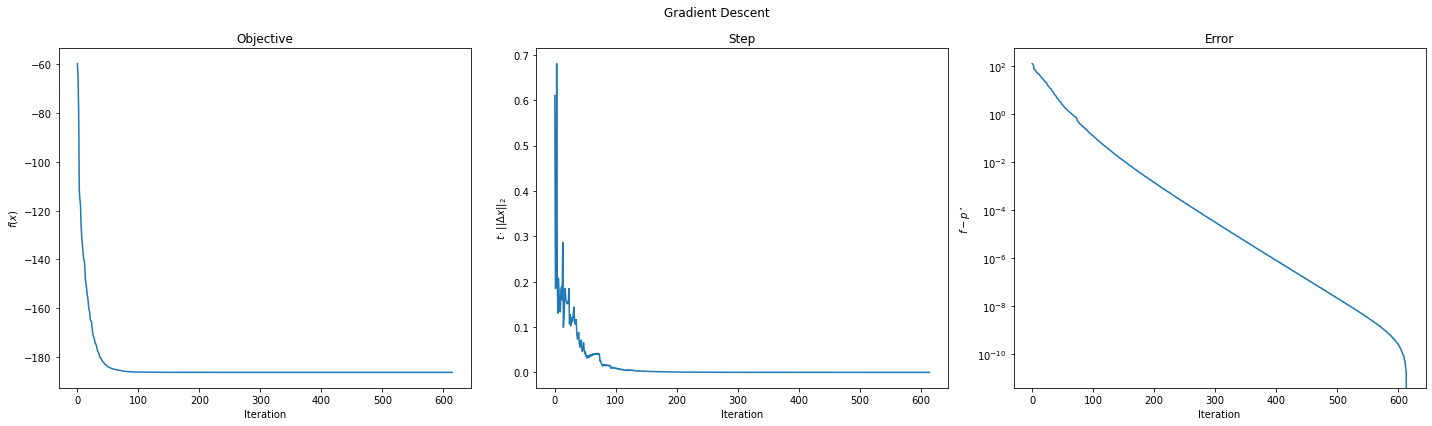

In [6]:
fig = plot(obj, steps, xs, "Gradient Descent")

In [7]:
steps2, xs2 = newtons_method(obj, grad, hess, x0, alpha, beta, tol)

Optimal value -186.2072 found in 347 iterations and 0.22 seconds.


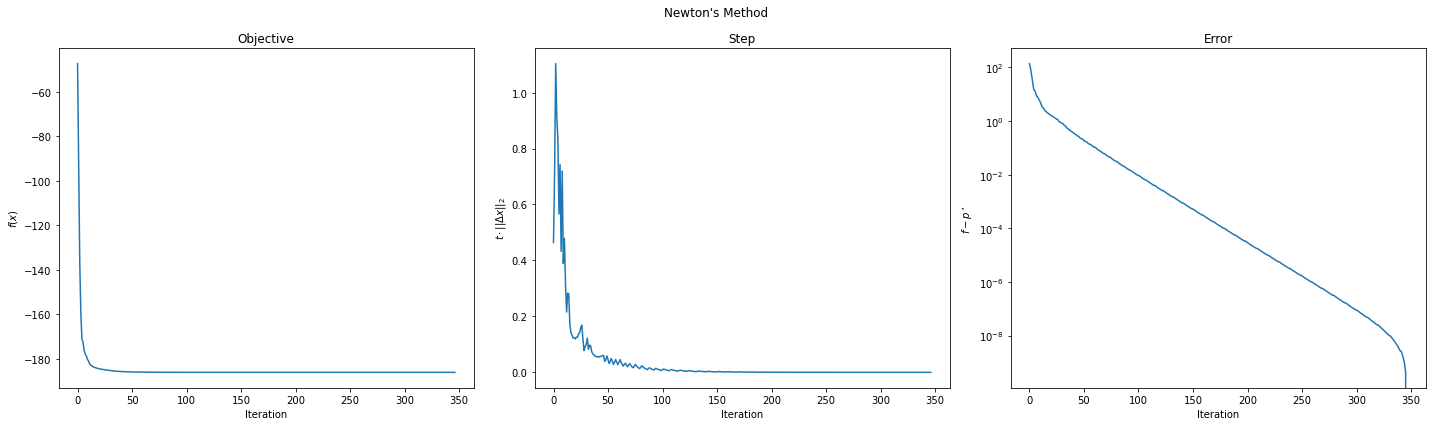

In [8]:
fig = plot(obj, steps2, xs2, "Newton's Method")

## Question 3: Flux balance analysis in systems biology
Flux balance analysis is based on a very simple model of the reactions going on in a cell, keeping track only of the gross rate of consumption and production of various chemical species within the cell. Based on the known stoichiometry of the reactions, and known upper bounds on some of the reaction rates, we can compute bounds on the other reaction rates, or cell growth, for example.

We focus on $m$ metabolites in a cell, labeled $M_1,\ldots, M_m$. There are $n$ reactions going on, labeled $R_1, \ldots, R_n$, with nonnegative reaction rates $v_1, \ldots, v_n$. Each reaction has a (known) stoichiometry, which tells us the rate of consumption and production of the metabolites per unit of reaction rate. The stoichiometry data is given by the *stoichiometry matrix* $S \in \mathbf{R}^{m \times n}$, defined as follows: $S_{ij}$ is the rate of production of $M_i$ due to unit reaction rate $v_j=1$. Here we consider consumption of a metabolite as negative production; so $S_{ij}=−2$, for example, means that reaction $R_j$ causes metabolite $M_i$ to be consumed at a rate $2v_j$.

As an example, suppose reaction $R_1$ has the form $M_1 \rightarrow M_2 + 2 M_3$ The consumption rate of $M_1$, due to this reaction, is $v_1$; the production rate of $M_2$ is  $v_1$; and the production rate of $M_3$ is $2v_1$. (The reaction $R_1$ has no effect on metabolites $M_4, \ldots, M_m$.) This corresponds to a first column of $S$ of the form  $(−1,1,2,0,…,0)$.

Reactions are also used to model flow of metabolites into and out of the cell. For example, suppose that reaction $R_2$ corresponds to the flow of metabolite $M_1$ into the cell, with $v_2$ giving the flow rate. This corresponds to a second column of $S$ of the form $(1,0,…,0)$.

The last reaction, $R_n$ , corresponds to biomass creation, or cell growth, so the reaction rate $v_n$ is the cell growth rate. The last column of $S$ gives the amounts of metabolites used or created per unit of cell growth rate.

Since our reactions include metabolites entering or leaving the cell, as well as those converted to biomass within the cell, we have conservation of the metabolites, which can be expressed as $Sv=0$. In addition, we are given upper limits on some of the reaction rates, which we express as $v \preceq v^\mathrm{max}$, where we set $v^\mathrm{max}_j=\infty$ if no upper limit on reaction rate $j$ is known. The goal is to find the maximum possible cell growth rate (i.e., largest possible value of $v_n$) consistent with the constraints
$$
Sv = 0, \qquad v \succeq 0, \qquad v \preceq v^\mathrm{max}.
$$
The questions below pertain to the data found in `fba_data.m`.

In [9]:
# data file for flux balance analysis in systems biology
# From Segre, Zucker et al "From annotated genomes to metabolic flux
# models and kinetic parameter fitting" OMICS 7 (3), 301-316.

S = np.array(
    [  # Stoichiometric matrix
        # M1 M2	M3 M4 M5 M6
        [1, 0, 0, 0, 0, 0],  # R1:  extracellular -->  M1
        [-1, 1, 0, 0, 0, 0],  # R2:  M1 -->  M2
        [-1, 0, 1, 0, 0, 0],  # R3:  M1 -->  M3
        [0, -1, 0, 2, -1, 0],  # R4:  M2 + M5 --> 2 M4
        [0, 0, 0, 0, 1, 0],  # R5:  extracellular -->  M5
        [0, -2, 1, 0, 0, 1],  # R6:  2 M2 -->  M3 + M6
        [0, 0, -1, 1, 0, 0],  # R7:  M3 -->  M4
        [0, 0, 0, 0, 0, -1],  # R8:  M6 --> extracellular
        [0, 0, 0, -1, 0, 0],  # R9:  M4 --> cell biomass
    ]
).T

m, n = S.shape
vmax = np.array(
    [
        10.10,  # R1:  extracellular -->  M1
        100,  # R2:  M1 -->  M2
        5.90,  # R3:  M1 -->  M3
        100,  # R4:  M2 + M5 --> 2 M4
        3.70,  # R5:  extracellular -->  M5
        100,  # R6:  2 M2 --> M3 + M6
        100,  # R7:  M3 -->  M4
        100,  # R8:  M6 -->  extracellular
        100,  # R9:  M4 -->  cell biomass
    ]
)

(a) What the maximum possible cell growth rate  $G^\star$?

In [10]:
v = cp.Variable(n, nonneg=True)
constraints = [S @ v == 0, v <= vmax]
obj = cp.Maximize(v[-1])
prob = cp.Problem(obj, constraints)

In [11]:
prob.solve()

13.54999999695169

In [12]:
v.value

array([10.1 ,  4.2 ,  5.9 ,  3.7 ,  3.7 ,  0.25,  6.15,  0.25, 13.55])

Which of the reaction rate limits have nonzero optimal Lagrange multipliers?

In [14]:
binding_constraints = [
    (i, λ) for i, λ in enumerate(constraints[1].dual_value, start=1) if λ > 1e-10
]
binding_constraints

[(1, 0.5000000015465667), (3, 0.49999999885838103), (5, 1.499999999084475)]

Which of the reaction rate limits is the maximum growth rate most sensitive to?

In [15]:
max(binding_constraints, key=lambda x: x[1])

(5, 1.499999999084475)

(b) Essential genes and synthetic lethals. For simplicity, we'll assume that each reaction is controlled by an associated gene, i.e., gene $G_i$ controls reaction $R_i$. Knocking out a set of genes associated with some reactions has the effect of setting the reaction rates (or equivalently, the associated $v^\max$ entries) to zero, which of course reduces the maximum possible growth rate. If the maximum growth rate becomes small enough or zero, it is reasonable to guess that knocking out the set of genes will kill the cell. An essential gene is one that when knocked out reduces the maximum growth rate below a given threshold $G^\min$. (Note that $G_n$ is always an essential gene.) A synthetic lethal is a pair of non-essential genes that when knocked out reduces the maximum growth rate below the threshold. Find all essential genes and synthetic lethals for the given problem instance, using .

Given the threshold $G^\mathrm{min} = 0.2 G^\star$, which of the following genes are essential?

In [16]:
G_min = 0.2 * prob.value
G_min

2.7099999993903383

In [17]:
for i in range(n):
    new_constraints = constraints + [v[i] == 0]
    assert len(new_constraints) == len(constraints) + 1
    new_prob = cp.Problem(obj, new_constraints)
    G_new = new_prob.solve()
    if G_new < G_min:
        print(f"v_{i+1} is an essential gene: G_new={G_new:0.3f}")
    else:
        print(f"v_{i+1} is NOT an essential gene: G_new={G_new:0.3f}")

v_1 is an essential gene: G_new=0.000
v_2 is NOT an essential gene: G_new=5.900
v_3 is NOT an essential gene: G_new=10.600
v_4 is NOT an essential gene: G_new=8.000
v_5 is NOT an essential gene: G_new=8.000
v_6 is NOT an essential gene: G_new=13.300
v_7 is NOT an essential gene: G_new=7.400
v_8 is NOT an essential gene: G_new=13.300
v_9 is an essential gene: G_new=-0.000


Given the threshold $G^\mathrm{min} = 0.2 G^\star$, which of the following gene pairs are synthetic lethals?

In [18]:
gene_pairs = (
    (2, 3),
    (2, 5),
    (2, 7),
    (3, 4),
    (4, 6),
    (4, 7),
    (5, 6),
    (5, 7),
    (6, 8),
    (7, 8),
)

In [19]:
for i, j in gene_pairs:
    new_constraints = constraints + [v[i - 1] == 0, v[j - 1] == 0]
    assert len(new_constraints) == len(constraints) + 2
    new_prob = cp.Problem(obj, new_constraints)
    G_new = new_prob.solve()
    if G_new < G_min:
        print(f"(v_{i},v_{j}) is a synthetic lethal: G_new={G_new:0.3f}")
    else:
        print(f"(v_{i},v_{j}) is NOT: G_new={G_new:0.3f}")

(v_2,v_3) is a synthetic lethal: G_new=-0.000
(v_2,v_5) is NOT: G_new=5.900
(v_2,v_7) is a synthetic lethal: G_new=0.000
(v_3,v_4) is NOT: G_new=5.050
(v_4,v_6) is NOT: G_new=5.900
(v_4,v_7) is a synthetic lethal: G_new=-0.000
(v_5,v_6) is NOT: G_new=5.900
(v_5,v_7) is a synthetic lethal: G_new=-0.000
(v_6,v_8) is NOT: G_new=13.300
(v_7,v_8) is NOT: G_new=7.400


## Question 4: Online advertising displays
When a user goes to a website, one of a set of $n$ ads, labeled  $1,...,n$, is displayed. This is called an *impression*. We divide some time interval (say, one day) into $T$ periods, labeled $t=1,...,T$. Let  $N_{it}\ge0$ denote the number of impressions in period $t$ for which we display ad $i$. In period $t$ there will be a total of $I_t>0$ impressions, so we must have $\sum_{i=1}^n N_{it} = I_t$, for $t=1, \ldots, T$. (The numbers $I_t$ might be known from past history.) You can treat all these numbers as real. (This is justified since they are typically very large.)

The revenue for displaying ad $i$ in period $t$ is $R_{it} \geq 0$ per impression. (This might come from click-through payments, for example.) The total revenue is $\sum_{t=1}^T \sum_{i=1}^n R_{it} N_{it}$. To maximize revenue, we would simply display the ad with the highest revenue per impression, and no other, in each display period.

We also have in place a set of  𝑚  contracts that require us to display certain numbers of ads, or mixes of ads (say, associated with the products of one company), over certain periods, with a penalty for any shortfalls. Contract $j$ is characterized by a set of ads $\mathcal A_j \subseteq \{1,\ldots, n\}$ (while it does not affect the math, these are often disjoint), a set of periods $\mathcal T_j \subseteq \{1, \ldots, T\}$, a target number of impressions $q_j \ge 0$, and a shortfall penalty rate $p_j > 0$.

The *shortfall* $s_j$ for contract $j$ is
$$
s_j = \left( q_j - \sum_{t \in \mathcal T_j} \sum_{i \in A_j} N_{it}\right)_+,
$$
where $(u)_+$  means $\max\{u,0\}$. (This is the number of impressions by which we fall short of the target value $q_j$.) Our contracts require a total penalty payment equal to $\sum_{j=1}^m p_j s_j$. Our net profit is the total revenue minus the total penalty payment.

Use convex optimization to find the display numbers $N_{it}$ that maximize net profit. The data in this problem are $R \in \mathbf{R}^{n \times T}$, $I\in \mathbf{R}^T$ (here $I$ is the vector of impressions, not the identity matrix), and the contract data $\mathcal A_j$, $mathcal T_j$, $q_j$, and  $p_j$, $j =1, \ldots, m$.

Carry out your method on the problem with data given in `ad_disp_data.m`. The data $\mathcal A_j$ and $mathcal T_j$, for $j =1, \ldots, m$ are given by matrices $A^\mathrm{contr}\in \mathbf{R}^{n \times m}$ and $T^\mathrm{contr}\in \mathbf{R}^{T \times m}$, with

$$
A^\mathrm{contr}_{ij}=\left\{\begin{array}{ll}1 & i\in \mathcal A_j\\0 & \mbox{otherwise},\end{array}\right. \qquad T^\mathrm{contr}_{tj}=\left\{\begin{array}{ll}1 & t\in \mathcal T_j\\0 & \mbox{otherwise}.\end{array}\right.
$$

In [62]:
def read_matrix(filename, sep=","):
    matrix = []
    with open(filename, "r") as file:
        for line in file.readlines():
            row = [float(x) for x in line.split(sep)]
            matrix.append(row)
    return np.array(matrix).squeeze()

In [70]:
# Data generated from MATLAB
I = read_matrix("I.txt")
R = read_matrix("R.txt")
q = read_matrix("q.txt")
p = read_matrix("p.txt")
T_contr = read_matrix("T_contr.txt").astype(bool)
A_contr = read_matrix("A_contr.txt").astype(bool)

n = R.shape[0]  # number of ads
m = q.shape[0]  # number of contracts
T = R.shape[1]  # number of periods

In [71]:
I.shape, R.shape, q.shape, p.shape, A_contr.shape, T_contr.shape

((60,), (100, 60), (30,), (30,), (100, 30), (60, 30))

### Solution 1: Using link variables

In [72]:
N = cp.Variable((n, T), nonneg=True)
link = cp.Variable(m, nonneg=True)

shortfalls = []
for qj, Aj, Tj in zip(q.ravel(), A_contr.T, T_contr.T):
    shortfall = qj - sum(
        N[i, j]
        for (i, a), (j, t) in itertools.product(enumerate(Aj), enumerate(Tj))
        if a == 1 and t == 1
    )
    shortfalls.append(shortfall)

constraints = [l >= s for l, s in zip(link, shortfalls)]
constraints += [cp.sum(N, axis=0) == I]

revenue = cp.sum(cp.multiply(R, N))
penalty_payment = p @ link
obj = cp.Maximize(revenue - penalty_payment)
prob = cp.Problem(obj, constraints)

In [73]:
prob.solve()

230.56651562462235

In [74]:
revenue.value, penalty_payment.value

(268.2323449188094, 37.665829289797315)

### Solution 2: Formulating the penatly as positive part of diagonal.

In [75]:
N2 = cp.Variable((n, T), nonneg=True)

constraints2 = [cp.sum(N2, axis=0) == I]

revenue2 = cp.sum(cp.multiply(R, N2))
penalty_payment2 = p @ cp.pos(q - cp.diag(A_contr.T @ N2 @ T_contr))

obj2 = cp.Maximize(revenue2 - penalty_payment2)
prob2 = cp.Problem(obj2, constraints2)

In [76]:
prob2.solve()

230.56651562462224

What is the optimal net profit?

In [78]:
prob.value

230.56651562462235

What is the revenue associated with the optimal net profit?

In [79]:
revenue.value

268.2323449188094

What is the total penalty payment associated with the optimal net profit?

In [80]:
penalty_payment.value

37.665829289797315

What is the net profit if we were to display only the ad with the largest revenue per impression?

In [138]:
N3 = cp.Variable((n, T), nonneg=True)
constraints3 = [cp.sum(N3, axis=0) == I]
revenue3 = cp.sum(cp.multiply(R, N3))
obj3 = cp.Maximize(revenue3)
prob3 = cp.Problem(obj3, constraints3)

In [139]:
prob3.solve()

305.1017911244956

In [141]:
penalty_payment3 = p @ cp.pos(q - cp.diag(A_contr.T @ N3 @ T_contr))
net_profit3 = revenue3.value - penalty_payment3.value
net_profit3

72.84233040872351

What is the revenue if we were to display only the ad with the largest revenue per impression?

In [142]:
revenue3.value

305.10179112449526

What is the total penalty if we were to display only the ad with the largest revenue per impression?

In [143]:
penalty_payment3.value

232.25946071577175

## Question 5: Ranking by aggregating preferences
